In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import torch.nn.functional as F


import torchvision
from torchvision.models import resnet18, ResNet18_Weights, vgg16, VGG16_Weights
from torchvision import datasets
from torchvision import transforms

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


import os
from torchsummary import summary



# from google.colab import drive
# drive.mount('/content/drive')
# #Code folder path
# %cd /content/drive/My Drive/ECE591_DL_CL_PROJECT/

#device config
torch.cuda.set_device(1)#Select GPU device 1
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")


#Datasets
#Tiny-imagenet: http://cs231n.stanford.edu/tiny-imagenet-200.zip
#Tiny-imagenet-C: https://zenodo.org/records/2469796

#CIFAR-10:  https://www.cs.toronto.edu/~kriz/cifar.html
#CIFAR-10C: https://zenodo.org/records/2535967


In [2]:
# Returns a list of transformations when called

class GetTransforms():
    '''Returns a list of transformations when type as requested amongst train/test
       Transforms('train') = list of transforms to apply on training data
       Transforms('test') = list of transforms to apply on testing data'''

    def __init__(self):
        pass

    def trainparams(self):
        train_transformations = [ #resises the image so it can be perfect for our model.
            transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
            transforms.RandomRotation((-7,7)),     #Rotates the image to a specified angel
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
            transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)) #Normalize all the images
            ]

        return train_transformations

    def testparams(self):
        test_transforms = [
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)) #Normalize all the images
        ]
        return test_transforms

transformations = GetTransforms()
train_transforms = transforms.Compose(transformations.trainparams())#transforms.Compose(
test_transforms = transforms.Compose(transformations.testparams()) #transforms.Compose(

In [3]:
#Download CIFAR-10 Dataset
class GetCIFAR10_TrainData():
    def __init__(self, dir_name:str):
        self.dirname = dir_name

    def download_train_data(self):
        return datasets.CIFAR10(self.dirname, train=True, download=True, transform=train_transforms)

    def download_test_data(self):
        return datasets.CIFAR10(self.dirname, train=False, download=True, transform=test_transforms)

data = GetCIFAR10_TrainData('./Datasets/CIFAR-10')
trainset = data.download_train_data()
testset = data.download_test_data()


trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
class Vgg16(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2, dilation=1),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2, dilation=1),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2, dilation=1),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2, dilation=1),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2, dilation=1)
        )
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return F.log_softmax(x, dim=-1)

model = Vgg16(num_classes=10).to(device)
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [5]:
def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses):

    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target) #negative log likelihood loss


        train_losses.append(loss.item())
        loss.backward()
        optimizer.step() #Performs a single optimization step (parameter update).

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        # print statistics
        running_loss += loss.item()
        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified = []):

    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # label = 0
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    with torch.no_grad():

        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)

            for d,i,j in zip(data, pred, target):
                if i != j:
                    misclassified.append([d.cpu(),i[0].cpu(),j.cpu()])

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))

    test_acc.append(100. * correct / len(test_dataloader.dataset))
    return misclassified


In [6]:
# Training the model
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)


train_acc = []
train_losses = []
test_acc = []
test_losses = []

EPOCHS = 100

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses)
    scheduler.step(train_losses[-1])
    misclassified = model_testing(model, device, testloader, test_acc, test_losses)
    
    if i%10==0:
        torch.save(model.state_dict(), "./Networks/VGG16_CIFAR10_V0.pt")
        np.savez("./Networks/TrainSteps_VGG16_CIFAR10_V0.npz", train_losses=train_losses,train_acc=train_acc, test_losses=test_losses, test_acc=test_acc)

torch.save(model.state_dict(), "./Networks/VGG16_CIFAR10_V0.pt")
np.savez("./Networks/TrainSteps_VGG16_CIFAR10_V0.npz", train_losses=train_losses,train_acc=train_acc, test_losses=test_losses, test_acc=test_acc)

EPOCHS : 0


Loss=0.9595233201980591 Batch_id=195 Accuracy=44.72: 100%|██████████| 196/196 [00:59<00:00,  3.30it/s]



Test set: Average loss: 1.4200, Accuracy: 5164/10000 (51.64%)

EPOCHS : 1


Loss=1.0412296056747437 Batch_id=195 Accuracy=63.18: 100%|██████████| 196/196 [01:01<00:00,  3.18it/s]



Test set: Average loss: 0.9506, Accuracy: 6646/10000 (66.46%)

EPOCHS : 2


Loss=0.7561933398246765 Batch_id=195 Accuracy=70.66: 100%|██████████| 196/196 [01:01<00:00,  3.21it/s]



Test set: Average loss: 0.7817, Accuracy: 7341/10000 (73.41%)

EPOCHS : 3


Loss=0.6531176567077637 Batch_id=195 Accuracy=75.58: 100%|██████████| 196/196 [01:01<00:00,  3.17it/s]



Test set: Average loss: 0.6876, Accuracy: 7677/10000 (76.77%)

EPOCHS : 4


Loss=0.49402371048927307 Batch_id=195 Accuracy=77.60: 100%|██████████| 196/196 [01:01<00:00,  3.17it/s]



Test set: Average loss: 0.6069, Accuracy: 7968/10000 (79.68%)

EPOCHS : 5


Loss=0.509687066078186 Batch_id=195 Accuracy=80.10: 100%|██████████| 196/196 [01:01<00:00,  3.19it/s]  



Test set: Average loss: 0.5505, Accuracy: 8131/10000 (81.31%)

EPOCHS : 6


Loss=0.43076270818710327 Batch_id=195 Accuracy=81.64: 100%|██████████| 196/196 [01:02<00:00,  3.14it/s]



Test set: Average loss: 0.5499, Accuracy: 8173/10000 (81.73%)

EPOCHS : 7


Loss=0.44673076272010803 Batch_id=195 Accuracy=83.32: 100%|██████████| 196/196 [01:01<00:00,  3.16it/s]



Test set: Average loss: 0.5446, Accuracy: 8205/10000 (82.05%)

EPOCHS : 8


Loss=0.43104758858680725 Batch_id=195 Accuracy=84.45: 100%|██████████| 196/196 [01:01<00:00,  3.19it/s]



Test set: Average loss: 0.5103, Accuracy: 8263/10000 (82.63%)

EPOCHS : 9


Loss=0.36710119247436523 Batch_id=195 Accuracy=85.17: 100%|██████████| 196/196 [01:01<00:00,  3.20it/s]



Test set: Average loss: 0.5062, Accuracy: 8323/10000 (83.23%)

EPOCHS : 10


Loss=0.5003742575645447 Batch_id=195 Accuracy=86.45: 100%|██████████| 196/196 [01:01<00:00,  3.20it/s] 



Test set: Average loss: 0.5789, Accuracy: 8159/10000 (81.59%)

EPOCHS : 11


Loss=0.43001484870910645 Batch_id=195 Accuracy=87.53: 100%|██████████| 196/196 [01:01<00:00,  3.17it/s]



Test set: Average loss: 0.5658, Accuracy: 8190/10000 (81.90%)

EPOCHS : 12


Loss=0.22909951210021973 Batch_id=195 Accuracy=87.81: 100%|██████████| 196/196 [01:02<00:00,  3.16it/s]



Test set: Average loss: 0.4561, Accuracy: 8501/10000 (85.01%)

EPOCHS : 13


Loss=0.352038711309433 Batch_id=195 Accuracy=88.91: 100%|██████████| 196/196 [01:01<00:00,  3.17it/s]  



Test set: Average loss: 0.4591, Accuracy: 8487/10000 (84.87%)

EPOCHS : 14


Loss=0.3081315755844116 Batch_id=195 Accuracy=89.20: 100%|██████████| 196/196 [01:01<00:00,  3.17it/s] 



Test set: Average loss: 0.4506, Accuracy: 8567/10000 (85.67%)

EPOCHS : 15


Loss=0.23009975254535675 Batch_id=195 Accuracy=89.97: 100%|██████████| 196/196 [01:01<00:00,  3.20it/s]

Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.



Test set: Average loss: 0.5391, Accuracy: 8373/10000 (83.73%)

EPOCHS : 16


Loss=0.1933521181344986 Batch_id=195 Accuracy=92.72: 100%|██████████| 196/196 [01:01<00:00,  3.19it/s] 



Test set: Average loss: 0.3617, Accuracy: 8835/10000 (88.35%)

EPOCHS : 17


Loss=0.24461200833320618 Batch_id=195 Accuracy=93.95: 100%|██████████| 196/196 [01:01<00:00,  3.21it/s]



Test set: Average loss: 0.3590, Accuracy: 8863/10000 (88.63%)

EPOCHS : 18


Loss=0.0652560219168663 Batch_id=195 Accuracy=94.34: 100%|██████████| 196/196 [01:01<00:00,  3.20it/s] 



Test set: Average loss: 0.3622, Accuracy: 8893/10000 (88.93%)

EPOCHS : 19


Loss=0.1481415033340454 Batch_id=195 Accuracy=94.65: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s] 



Test set: Average loss: 0.3626, Accuracy: 8888/10000 (88.88%)

EPOCHS : 20


Loss=0.08367405831813812 Batch_id=195 Accuracy=94.98: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s]



Test set: Average loss: 0.3642, Accuracy: 8892/10000 (88.92%)

EPOCHS : 21


Loss=0.2454337179660797 Batch_id=195 Accuracy=95.11: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s] 

Epoch 00022: reducing learning rate of group 0 to 2.5000e-05.



Test set: Average loss: 0.3666, Accuracy: 8895/10000 (88.95%)

EPOCHS : 22


Loss=0.16943171620368958 Batch_id=195 Accuracy=95.33: 100%|██████████| 196/196 [01:01<00:00,  3.18it/s]



Test set: Average loss: 0.3692, Accuracy: 8883/10000 (88.83%)

EPOCHS : 23


Loss=0.17860272526741028 Batch_id=195 Accuracy=95.37: 100%|██████████| 196/196 [01:01<00:00,  3.20it/s]



Test set: Average loss: 0.3647, Accuracy: 8917/10000 (89.17%)

EPOCHS : 24


Loss=0.09643822908401489 Batch_id=195 Accuracy=95.33: 100%|██████████| 196/196 [01:12<00:00,  2.72it/s]


Epoch 00025: reducing learning rate of group 0 to 1.2500e-06.

Test set: Average loss: 0.3706, Accuracy: 8890/10000 (88.90%)

EPOCHS : 25


Loss=0.11293469369411469 Batch_id=195 Accuracy=95.33: 100%|██████████| 196/196 [01:21<00:00,  2.39it/s]



Test set: Average loss: 0.3671, Accuracy: 8907/10000 (89.07%)

EPOCHS : 26


Loss=0.2010183334350586 Batch_id=195 Accuracy=95.34: 100%|██████████| 196/196 [01:22<00:00,  2.37it/s] 



Test set: Average loss: 0.3710, Accuracy: 8889/10000 (88.89%)

EPOCHS : 27


Loss=0.13604378700256348 Batch_id=195 Accuracy=95.48: 100%|██████████| 196/196 [01:23<00:00,  2.35it/s]

Epoch 00028: reducing learning rate of group 0 to 6.2500e-08.



Test set: Average loss: 0.3647, Accuracy: 8919/10000 (89.19%)

EPOCHS : 28


Loss=0.06230573728680611 Batch_id=195 Accuracy=95.33: 100%|██████████| 196/196 [01:22<00:00,  2.37it/s]



Test set: Average loss: 0.3648, Accuracy: 8906/10000 (89.06%)

EPOCHS : 29


Loss=0.12422704696655273 Batch_id=195 Accuracy=95.43: 100%|██████████| 196/196 [01:23<00:00,  2.36it/s]



Test set: Average loss: 0.3676, Accuracy: 8899/10000 (88.99%)

EPOCHS : 30


Loss=0.12495201826095581 Batch_id=195 Accuracy=95.36: 100%|██████████| 196/196 [01:22<00:00,  2.37it/s]



Test set: Average loss: 0.3683, Accuracy: 8896/10000 (88.96%)

EPOCHS : 31


Loss=0.13040797412395477 Batch_id=195 Accuracy=95.28: 100%|██████████| 196/196 [01:22<00:00,  2.36it/s]

Epoch 00032: reducing learning rate of group 0 to 3.1250e-09.



Test set: Average loss: 0.3671, Accuracy: 8898/10000 (88.98%)

EPOCHS : 32


Loss=0.11113572120666504 Batch_id=195 Accuracy=95.37: 100%|██████████| 196/196 [01:23<00:00,  2.36it/s]



Test set: Average loss: 0.3639, Accuracy: 8900/10000 (89.00%)

EPOCHS : 33


Loss=0.17595770955085754 Batch_id=195 Accuracy=95.38: 100%|██████████| 196/196 [01:24<00:00,  2.33it/s]



Test set: Average loss: 0.3661, Accuracy: 8908/10000 (89.08%)

EPOCHS : 34


Loss=0.09609000384807587 Batch_id=195 Accuracy=95.34: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]



Test set: Average loss: 0.3671, Accuracy: 8903/10000 (89.03%)

EPOCHS : 35


Loss=0.1369781643152237 Batch_id=195 Accuracy=95.30: 100%|██████████| 196/196 [01:21<00:00,  2.41it/s] 



Test set: Average loss: 0.3695, Accuracy: 8897/10000 (88.97%)

EPOCHS : 36


Loss=0.18676331639289856 Batch_id=195 Accuracy=95.40: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]



Test set: Average loss: 0.3666, Accuracy: 8906/10000 (89.06%)

EPOCHS : 37


Loss=0.11851803958415985 Batch_id=195 Accuracy=95.26: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]



Test set: Average loss: 0.3650, Accuracy: 8918/10000 (89.18%)

EPOCHS : 38


Loss=0.15022966265678406 Batch_id=195 Accuracy=95.44: 100%|██████████| 196/196 [01:21<00:00,  2.39it/s]



Test set: Average loss: 0.3662, Accuracy: 8908/10000 (89.08%)

EPOCHS : 39


Loss=0.19274559617042542 Batch_id=195 Accuracy=95.32: 100%|██████████| 196/196 [01:21<00:00,  2.40it/s]



Test set: Average loss: 0.3679, Accuracy: 8897/10000 (88.97%)

EPOCHS : 40


Loss=0.03997598960995674 Batch_id=195 Accuracy=95.45: 100%|██████████| 196/196 [01:23<00:00,  2.35it/s]



Test set: Average loss: 0.3659, Accuracy: 8911/10000 (89.11%)

EPOCHS : 41


Loss=0.13359194993972778 Batch_id=195 Accuracy=95.36: 100%|██████████| 196/196 [01:21<00:00,  2.40it/s]



Test set: Average loss: 0.3636, Accuracy: 8918/10000 (89.18%)

EPOCHS : 42


Loss=0.0763784721493721 Batch_id=195 Accuracy=95.14: 100%|██████████| 196/196 [01:21<00:00,  2.41it/s] 



Test set: Average loss: 0.3663, Accuracy: 8899/10000 (88.99%)

EPOCHS : 43


Loss=0.17809313535690308 Batch_id=195 Accuracy=95.28: 100%|██████████| 196/196 [01:23<00:00,  2.36it/s]



Test set: Average loss: 0.3656, Accuracy: 8908/10000 (89.08%)

EPOCHS : 44


Loss=0.20064692199230194 Batch_id=195 Accuracy=95.37: 100%|██████████| 196/196 [01:21<00:00,  2.41it/s]



Test set: Average loss: 0.3678, Accuracy: 8905/10000 (89.05%)

EPOCHS : 45


Loss=0.09640734642744064 Batch_id=195 Accuracy=95.46: 100%|██████████| 196/196 [01:22<00:00,  2.39it/s]



Test set: Average loss: 0.3657, Accuracy: 8920/10000 (89.20%)

EPOCHS : 46


Loss=0.13094674050807953 Batch_id=195 Accuracy=95.49: 100%|██████████| 196/196 [01:21<00:00,  2.39it/s]



Test set: Average loss: 0.3664, Accuracy: 8902/10000 (89.02%)

EPOCHS : 47


Loss=0.07055540382862091 Batch_id=195 Accuracy=95.29: 100%|██████████| 196/196 [01:22<00:00,  2.36it/s]



Test set: Average loss: 0.3675, Accuracy: 8911/10000 (89.11%)

EPOCHS : 48


Loss=0.15725252032279968 Batch_id=195 Accuracy=95.38: 100%|██████████| 196/196 [01:21<00:00,  2.40it/s]



Test set: Average loss: 0.3655, Accuracy: 8903/10000 (89.03%)

EPOCHS : 49


Loss=0.1581447571516037 Batch_id=195 Accuracy=95.40: 100%|██████████| 196/196 [01:21<00:00,  2.40it/s] 



Test set: Average loss: 0.3669, Accuracy: 8909/10000 (89.09%)

EPOCHS : 50


Loss=0.028169739991426468 Batch_id=195 Accuracy=95.33: 100%|██████████| 196/196 [01:22<00:00,  2.36it/s]



Test set: Average loss: 0.3672, Accuracy: 8909/10000 (89.09%)

EPOCHS : 51


Loss=0.11313873529434204 Batch_id=195 Accuracy=95.32: 100%|██████████| 196/196 [01:21<00:00,  2.41it/s]



Test set: Average loss: 0.3676, Accuracy: 8903/10000 (89.03%)

EPOCHS : 52


Loss=0.15709999203681946 Batch_id=195 Accuracy=95.35: 100%|██████████| 196/196 [01:22<00:00,  2.39it/s]



Test set: Average loss: 0.3657, Accuracy: 8907/10000 (89.07%)

EPOCHS : 53


Loss=0.13104769587516785 Batch_id=195 Accuracy=95.26: 100%|██████████| 196/196 [01:22<00:00,  2.39it/s]



Test set: Average loss: 0.3666, Accuracy: 8890/10000 (88.90%)

EPOCHS : 54


Loss=0.2457067221403122 Batch_id=195 Accuracy=95.28: 100%|██████████| 196/196 [01:22<00:00,  2.39it/s] 



Test set: Average loss: 0.3661, Accuracy: 8906/10000 (89.06%)

EPOCHS : 55


Loss=0.10774409770965576 Batch_id=195 Accuracy=95.25: 100%|██████████| 196/196 [01:23<00:00,  2.36it/s]



Test set: Average loss: 0.3674, Accuracy: 8897/10000 (88.97%)

EPOCHS : 56


Loss=0.18617238104343414 Batch_id=195 Accuracy=95.33: 100%|██████████| 196/196 [01:23<00:00,  2.36it/s]



Test set: Average loss: 0.3635, Accuracy: 8911/10000 (89.11%)

EPOCHS : 57


Loss=0.12373089790344238 Batch_id=195 Accuracy=95.36: 100%|██████████| 196/196 [01:21<00:00,  2.39it/s]



Test set: Average loss: 0.3647, Accuracy: 8912/10000 (89.12%)

EPOCHS : 58


Loss=0.04719282686710358 Batch_id=195 Accuracy=95.09: 100%|██████████| 196/196 [01:20<00:00,  2.42it/s] 



Test set: Average loss: 0.3657, Accuracy: 8909/10000 (89.09%)

EPOCHS : 59


Loss=0.11178489774465561 Batch_id=195 Accuracy=95.17: 100%|██████████| 196/196 [01:20<00:00,  2.42it/s]



Test set: Average loss: 0.3679, Accuracy: 8894/10000 (88.94%)

EPOCHS : 60


Loss=0.07310161739587784 Batch_id=195 Accuracy=95.40: 100%|██████████| 196/196 [01:21<00:00,  2.40it/s] 



Test set: Average loss: 0.3649, Accuracy: 8896/10000 (88.96%)

EPOCHS : 61


Loss=0.09927187860012054 Batch_id=195 Accuracy=95.29: 100%|██████████| 196/196 [01:23<00:00,  2.36it/s]



Test set: Average loss: 0.3640, Accuracy: 8904/10000 (89.04%)

EPOCHS : 62


Loss=0.06153586506843567 Batch_id=195 Accuracy=95.31: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]



Test set: Average loss: 0.3653, Accuracy: 8909/10000 (89.09%)

EPOCHS : 63


Loss=0.2265162467956543 Batch_id=195 Accuracy=95.23: 100%|██████████| 196/196 [01:21<00:00,  2.41it/s] 



Test set: Average loss: 0.3715, Accuracy: 8891/10000 (88.91%)

EPOCHS : 64


Loss=0.15096339583396912 Batch_id=195 Accuracy=95.46: 100%|██████████| 196/196 [01:21<00:00,  2.39it/s]



Test set: Average loss: 0.3651, Accuracy: 8907/10000 (89.07%)

EPOCHS : 65


Loss=0.11355229467153549 Batch_id=195 Accuracy=95.44: 100%|██████████| 196/196 [01:22<00:00,  2.37it/s]



Test set: Average loss: 0.3648, Accuracy: 8902/10000 (89.02%)

EPOCHS : 66


Loss=0.15514802932739258 Batch_id=195 Accuracy=95.38: 100%|██████████| 196/196 [01:21<00:00,  2.42it/s]



Test set: Average loss: 0.3678, Accuracy: 8898/10000 (88.98%)

EPOCHS : 67


Loss=0.08264802396297455 Batch_id=195 Accuracy=95.19: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]



Test set: Average loss: 0.3642, Accuracy: 8909/10000 (89.09%)

EPOCHS : 68


Loss=0.12363319098949432 Batch_id=195 Accuracy=95.29: 100%|██████████| 196/196 [01:21<00:00,  2.41it/s]



Test set: Average loss: 0.3676, Accuracy: 8892/10000 (88.92%)

EPOCHS : 69


Loss=0.17455466091632843 Batch_id=195 Accuracy=95.25: 100%|██████████| 196/196 [01:21<00:00,  2.39it/s]



Test set: Average loss: 0.3681, Accuracy: 8889/10000 (88.89%)

EPOCHS : 70


Loss=0.1995828002691269 Batch_id=195 Accuracy=95.31: 100%|██████████| 196/196 [01:22<00:00,  2.36it/s] 



Test set: Average loss: 0.3662, Accuracy: 8918/10000 (89.18%)

EPOCHS : 71


Loss=0.15400971472263336 Batch_id=195 Accuracy=95.24: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]



Test set: Average loss: 0.3673, Accuracy: 8899/10000 (88.99%)

EPOCHS : 72


Loss=0.17425306141376495 Batch_id=195 Accuracy=95.31: 100%|██████████| 196/196 [01:21<00:00,  2.41it/s] 



Test set: Average loss: 0.3688, Accuracy: 8894/10000 (88.94%)

EPOCHS : 73


Loss=0.23738881945610046 Batch_id=195 Accuracy=95.18: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]



Test set: Average loss: 0.3642, Accuracy: 8912/10000 (89.12%)

EPOCHS : 74


Loss=0.10249689966440201 Batch_id=195 Accuracy=95.41: 100%|██████████| 196/196 [01:22<00:00,  2.39it/s]



Test set: Average loss: 0.3670, Accuracy: 8916/10000 (89.16%)

EPOCHS : 75


Loss=0.13852660357952118 Batch_id=195 Accuracy=95.36: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]



Test set: Average loss: 0.3683, Accuracy: 8899/10000 (88.99%)

EPOCHS : 76


Loss=0.12343935668468475 Batch_id=195 Accuracy=95.40: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]



Test set: Average loss: 0.3644, Accuracy: 8910/10000 (89.10%)

EPOCHS : 77


Loss=0.08423406630754471 Batch_id=195 Accuracy=95.26: 100%|██████████| 196/196 [01:21<00:00,  2.41it/s]



Test set: Average loss: 0.3657, Accuracy: 8901/10000 (89.01%)

EPOCHS : 78


Loss=0.09535161405801773 Batch_id=195 Accuracy=95.34: 100%|██████████| 196/196 [01:21<00:00,  2.40it/s]



Test set: Average loss: 0.3675, Accuracy: 8911/10000 (89.11%)

EPOCHS : 79


Loss=0.088442362844944 Batch_id=195 Accuracy=95.32: 100%|██████████| 196/196 [01:21<00:00,  2.40it/s]  



Test set: Average loss: 0.3657, Accuracy: 8905/10000 (89.05%)

EPOCHS : 80


Loss=0.06300992518663406 Batch_id=195 Accuracy=95.31: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s]



Test set: Average loss: 0.3640, Accuracy: 8913/10000 (89.13%)

EPOCHS : 81


Loss=0.06286142021417618 Batch_id=195 Accuracy=95.42: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s]



Test set: Average loss: 0.3650, Accuracy: 8899/10000 (88.99%)

EPOCHS : 82


Loss=0.19669750332832336 Batch_id=195 Accuracy=95.32: 100%|██████████| 196/196 [01:21<00:00,  2.40it/s]



Test set: Average loss: 0.3662, Accuracy: 8897/10000 (88.97%)

EPOCHS : 83


Loss=0.14452409744262695 Batch_id=195 Accuracy=95.45: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]



Test set: Average loss: 0.3649, Accuracy: 8915/10000 (89.15%)

EPOCHS : 84


Loss=0.15761588513851166 Batch_id=195 Accuracy=95.36: 100%|██████████| 196/196 [01:01<00:00,  3.19it/s]



Test set: Average loss: 0.3642, Accuracy: 8925/10000 (89.25%)

EPOCHS : 85


Loss=0.15328291058540344 Batch_id=195 Accuracy=95.32: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]



Test set: Average loss: 0.3658, Accuracy: 8899/10000 (88.99%)

EPOCHS : 86


Loss=0.1880568563938141 Batch_id=195 Accuracy=95.33: 100%|██████████| 196/196 [00:41<00:00,  4.77it/s] 



Test set: Average loss: 0.3676, Accuracy: 8914/10000 (89.14%)

EPOCHS : 87


Loss=0.08662180602550507 Batch_id=195 Accuracy=95.31: 100%|██████████| 196/196 [00:40<00:00,  4.83it/s]



Test set: Average loss: 0.3683, Accuracy: 8901/10000 (89.01%)

EPOCHS : 88


Loss=0.14598140120506287 Batch_id=195 Accuracy=95.33: 100%|██████████| 196/196 [00:40<00:00,  4.84it/s]



Test set: Average loss: 0.3662, Accuracy: 8896/10000 (88.96%)

EPOCHS : 89


Loss=0.0727381557226181 Batch_id=195 Accuracy=95.38: 100%|██████████| 196/196 [00:40<00:00,  4.80it/s] 



Test set: Average loss: 0.3668, Accuracy: 8897/10000 (88.97%)

EPOCHS : 90


Loss=0.15759345889091492 Batch_id=195 Accuracy=95.25: 100%|██████████| 196/196 [00:41<00:00,  4.76it/s]



Test set: Average loss: 0.3645, Accuracy: 8912/10000 (89.12%)

EPOCHS : 91


Loss=0.2009967565536499 Batch_id=195 Accuracy=95.26: 100%|██████████| 196/196 [00:41<00:00,  4.74it/s] 



Test set: Average loss: 0.3657, Accuracy: 8898/10000 (88.98%)

EPOCHS : 92


Loss=0.13980673253536224 Batch_id=195 Accuracy=95.24: 100%|██████████| 196/196 [00:41<00:00,  4.77it/s]



Test set: Average loss: 0.3660, Accuracy: 8912/10000 (89.12%)

EPOCHS : 93


Loss=0.14550600945949554 Batch_id=195 Accuracy=95.39: 100%|██████████| 196/196 [00:40<00:00,  4.80it/s]



Test set: Average loss: 0.3691, Accuracy: 8880/10000 (88.80%)

EPOCHS : 94


Loss=0.08903845399618149 Batch_id=195 Accuracy=95.25: 100%|██████████| 196/196 [00:41<00:00,  4.72it/s]



Test set: Average loss: 0.3645, Accuracy: 8904/10000 (89.04%)

EPOCHS : 95


Loss=0.11125407367944717 Batch_id=195 Accuracy=95.32: 100%|██████████| 196/196 [00:41<00:00,  4.78it/s]



Test set: Average loss: 0.3642, Accuracy: 8915/10000 (89.15%)

EPOCHS : 96


Loss=0.07231771945953369 Batch_id=195 Accuracy=95.33: 100%|██████████| 196/196 [00:41<00:00,  4.73it/s]



Test set: Average loss: 0.3649, Accuracy: 8908/10000 (89.08%)

EPOCHS : 97


Loss=0.2217920571565628 Batch_id=195 Accuracy=95.44: 100%|██████████| 196/196 [00:41<00:00,  4.76it/s] 



Test set: Average loss: 0.3670, Accuracy: 8913/10000 (89.13%)

EPOCHS : 98


Loss=0.09600622951984406 Batch_id=195 Accuracy=95.21: 100%|██████████| 196/196 [00:41<00:00,  4.78it/s]



Test set: Average loss: 0.3669, Accuracy: 8907/10000 (89.07%)

EPOCHS : 99


Loss=0.14338882267475128 Batch_id=195 Accuracy=95.36: 100%|██████████| 196/196 [00:40<00:00,  4.84it/s]



Test set: Average loss: 0.3662, Accuracy: 8909/10000 (89.09%)



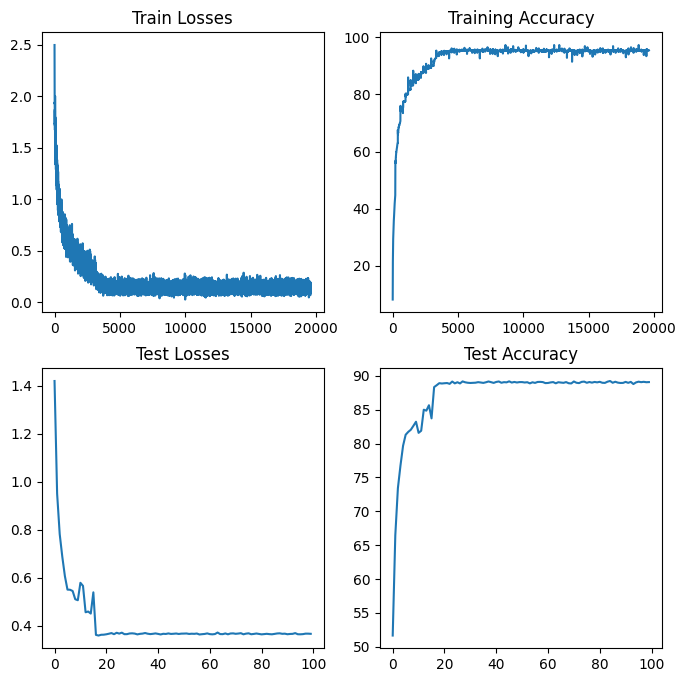

In [7]:
fig, axs = plt.subplots(2,2, figsize=(8,8))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)